In [447]:
from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

def load_saved_credentials():
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            return pickle.load(token)

def build_service():

    creds = load_saved_credentials()

    # If there are no (valid) credentials available, ask user to log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    return build('gmail', 'v1', credentials=creds)

In [467]:
import re
import time

service = build_service()
MAX_RESULTS=5
MAX_PAGES=1

def get_one_message(message_id):
    return service.users().messages().get(userId='me', id=message_id, format='metadata', metadataHeaders=['from']).execute()

def list_messages(max_pages, max_results):
    response = service.users().messages().list(userId='me',maxResults=max_results,labelIds=['INBOX']).execute()
    messages = response['messages']
    
    while 'nextPageToken' in response and max_pages > 0:
        page_token = response['nextPageToken']
        response = service.users().messages().list(userId='me',maxResults=max_results, labelIds=['INBOX'], pageToken=page_token).execute()
        messages.extend(response['messages'])
        max_pages-=1

    return messages

def get_sanitized_from(raw_message):
    raw_from = raw_message['payload']['headers'][0]['value']
    message_from = re.sub(r".*(@.*)\>",r"\1",raw_from)
    return message_from

def get_sanitized_day_of_year(raw_message):
    return time.strftime("%Y-%m-%d", time.localtime(int(raw_message['internalDate'])/1000))
    
def list_detailed_messages(max_pages, max_results):
    detailed_messages = []
    messages = list_messages(max_pages, max_results)
    for message in messages:
        raw_message = get_one_message(message['id'])
        detailed_message = {}
        detailed_message['id'] = raw_message['id']
        detailed_message['timestamp_date'] = raw_message['internalDate']
        detailed_message['day_of_year'] = get_sanitized_day_of_year(raw_message)
        detailed_message['from'] = get_sanitized_from(raw_message)
        detailed_messages.append(detailed_message)
    
    return detailed_messages

In [470]:
# request gmail api and cache result in memory
messages = list_detailed_messages(MAX_PAGES, 200)

In [469]:
# check cached messages
messages

[{'id': '16de0a8f7f46d8a2',
  'timestamp_date': '1571431760000',
  'day_of_year': '2019-10-18',
  'from': '@spotify.com'},
 {'id': '16de00d6056b69da',
  'timestamp_date': '1571421920000',
  'day_of_year': '2019-10-18',
  'from': '@quintoandar.com.br'},
 {'id': '16ddf7f30c02db94',
  'timestamp_date': '1571412715000',
  'day_of_year': '2019-10-18',
  'from': '@fwd.drifttmail.com'},
 {'id': '16ddf35dbbfe6e2b',
  'timestamp_date': '1571407907000',
  'day_of_year': '2019-10-18',
  'from': '@circleci.com'},
 {'id': '16ddf30022012859',
  'timestamp_date': '1571407524000',
  'day_of_year': '2019-10-18',
  'from': '@circleci.com'},
 {'id': '16ddedcb4363234d',
  'timestamp_date': '1571402068000',
  'day_of_year': '2019-10-18',
  'from': '@amazon.com.br'},
 {'id': '16dde87f83416448',
  'timestamp_date': '1571363003000',
  'day_of_year': '2019-10-17',
  'from': '@accounts.google.com'},
 {'id': '16ddd8dcbfcf319f',
  'timestamp_date': '1571380119000',
  'day_of_year': '2019-10-18',
  'from': '@clubh

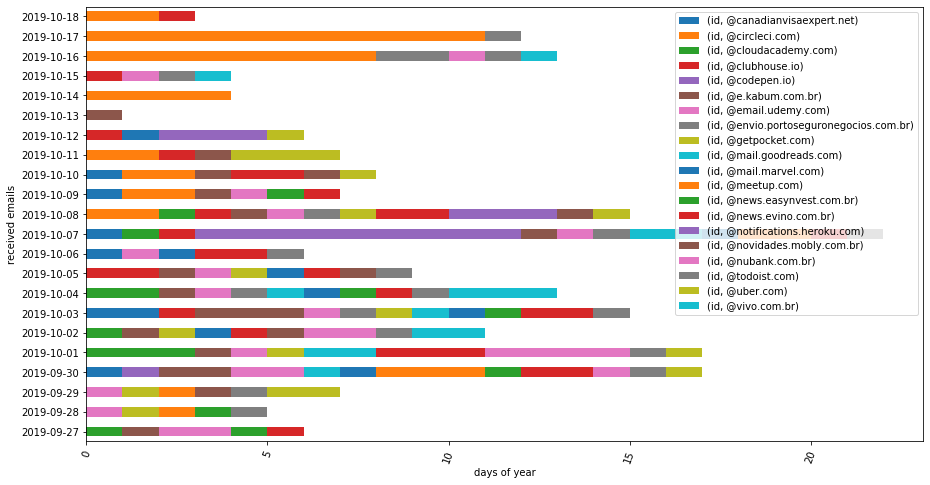

In [507]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.DataFrame(messages).drop('timestamp_date',1)

def get_top_senders(number_of_senders, data):
    frequency_series = data['from'].value_counts()
    return frequency_series.head(number_of_senders).index.tolist()    

def filter_email_by_senders(senders, data):
    return data[data['from'].isin(senders)]

def plot_graph(data):
    grouped_data = data.groupby(['day_of_year','from']).count()
    grouped_data.unstack().fillna(0).plot(figsize=(15, 8), kind="barh", stacked=True)
    plt.legend(loc='upper right')
    plt.ylabel('received emails')
    plt.xlabel('days of year')
    plt.xticks(rotation=70)
    plt.show()
    
top_senders = get_top_senders(20, data)
plot_graph(filter_email_by_senders(top_senders, data))

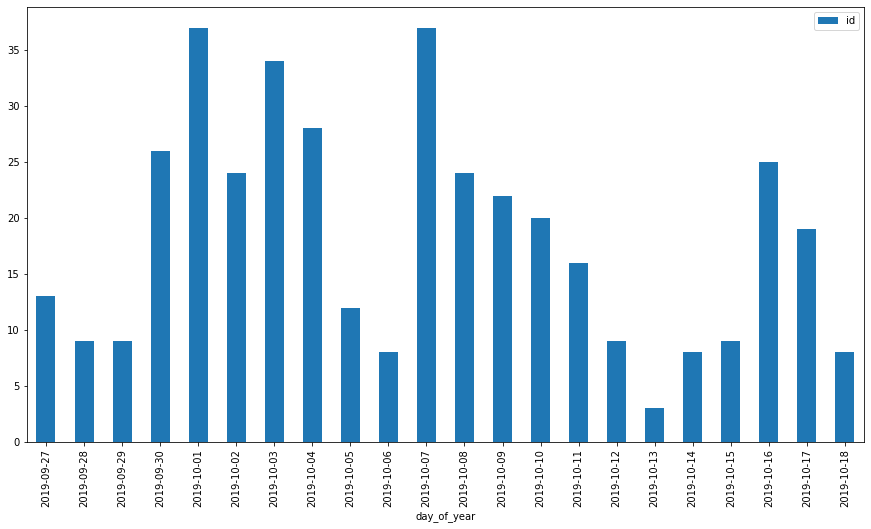

In [508]:
data.drop('from',1).groupby(['day_of_year']).count().plot(figsize=(15, 8), kind="bar")

In [506]:
avg_emails_received_per_day = data.drop('from',1).groupby(['day_of_year']).count().mean().values[0]
print('AVG number of emails received per day:', int(avg_emails_received_per_day))

AVG number of emails received per day: 18
